In [1]:
import os
import numpy as np
import pandas as pd
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType
from umap import UMAP
import umap.plot
import matplotlib.pyplot as plt
import time
import datetime

/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
exec(open(os.path.join(os.environ["SPARK_HOME"], 'python/pyspark/shell.py')).read())
app_name = 'umapVisualization'
master = 'local'
spark = SparkSession.builder.appName(app_name).master(master).getOrCreate()

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.4.5
      /_/

Using Python version 3.7.3 (default, Mar 27 2019 16:54:48)
SparkSession available as 'spark'.


### Read in relevant data

In [3]:
genre_path = 'goodreads_book_genres_initial.json'
book_id_map_path = 'book_id_map.parquet'
itemFactors_path = 'itemFactors_10_0.01_100_percent.parquet'

In [4]:
genre = spark.read.json(genre_path)
book_id_map = spark.read.parquet(book_id_map_path)
itemFactors = spark.read.parquet(itemFactors_path)

In [5]:
def find_key_with_max_value(dic):
    if np.sum(np.array(list(dic.values())) != None) == 0:
        return None
    else:
        for k, v in dic.items():
            if v is None:
                dic[k] = 0
        return max(dic, key = dic.get)

In [6]:
genre.show(5)

+-------+--------------------+
|book_id|              genres|
+-------+--------------------+
|5333265|       [,,,, 1,,,,,]|
|1333909|   [,,, 219, 5,,,,,]|
|7327624|[,, 31, 8,, 1,, 1,,]|
|6066819|[,,, 555,, 10,,, ...|
| 287140|       [,,,,,, 3,,,]|
+-------+--------------------+
only showing top 5 rows



In [6]:
# extract the genre with highest value for each book
genre_array = genre.collect()
bookid2genre = {genre_array[i][0]: find_key_with_max_value(genre_array[i][1].asDict()) for i in range(len(genre_array))}
bookid_genre_df = pd.DataFrame({'book_id': list(bookid2genre.keys()), 'genre': list(bookid2genre.values())})
bookid_genre_spark_df = spark.createDataFrame(bookid_genre_df)
id_genre_spark_df = bookid_genre_spark_df.join(book_id_map, on = 'book_id', how = 'inner').drop('book_id').withColumnRenamed('book_id_csv', 'id')

# id is string type, we change it to int for later join
id_genre_spark_df = id_genre_spark_df.withColumn('id', id_genre_spark_df['id'].cast(IntegerType()))

# explode item factors
itemFactors_exploded = itemFactors.select("id", itemFactors.features[0], itemFactors.features[1], itemFactors.features[2], itemFactors.features[3], itemFactors.features[4], \
                                                itemFactors.features[5], itemFactors.features[6], itemFactors.features[7], itemFactors.features[8], itemFactors.features[9])

id_itemFactor_spark_df = id_genre_spark_df.join(itemFactors_exploded, on = 'id', how = 'inner' )

# extract factors as 10-dimension vectors
data = np.array(id_itemFactor_spark_df.select('features[0]', 'features[1]', 'features[2]', 'features[3]', 'features[4]', 'features[5]', 'features[6]', 'features[7]', 'features[8]', 'features[9]').collect())

# extract labels, some book doesn't have any label so change that to 'none' genre
labels = np.array(['none' if label is None else label for label in [row[0] for row in id_itemFactor_spark_df.select('genre').collect()]])

### UMAP Visualization

In [17]:
# randomly draw 400k samples from data and labels for computation efficiency
np.random.seed = 66
samples_indices = np.random.choice(np.arange(data.shape[0]), size = 400000, replace = False)
sample_data, sample_labels = data[samples_indices], labels[samples_indices]

In [18]:
start_time = time.time()

In [ ]:
mapper = UMAP(random_state=66, n_components=2, verbose = True).fit(sample_data)

UMAP(a=None, angular_rp_forest=False, b=None,
   force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
   local_connectivity=1.0, low_memory=False, metric='euclidean',
   metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
   output_metric_kwds=None, random_state=66, repulsion_strength=1.0,
   set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
   target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
   transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Sun May 10 23:45:38 2020 Finding Nearest Neighbors
Sun May 10 23:45:38 2020 Building RP forest with 44 trees


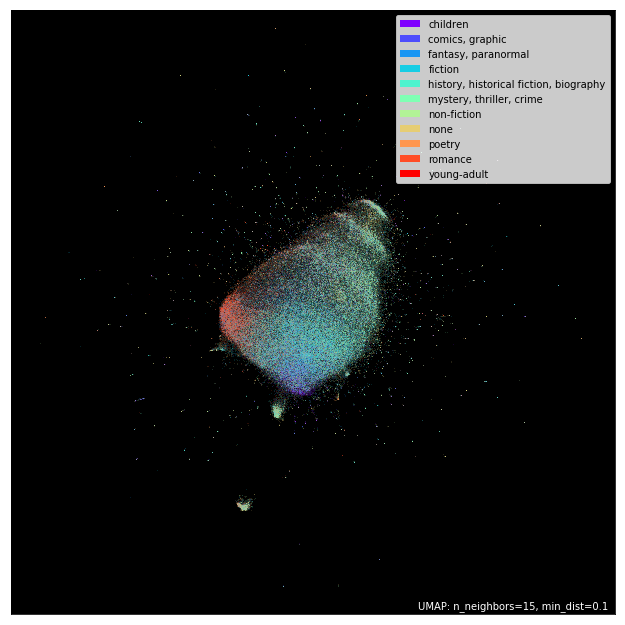

In [12]:
umap.plot.points(mapper, labels = sample_labels, theme = 'fire')
plt.savefig('10_0.01_100_percent_400k_66.eps')

In [13]:
end_time = time.time()

In [14]:
str(datetime.timedelta(seconds = end_time - start_time))

'0:42:30.724137'